In [1]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
%matplotlib inline

# Import data

In [130]:
training_set = pd.read_csv("gps_data.csv")
training_label = pd.read_csv("Training Set Labels.csv")

data = pd.merge(training_set, training_label, how="left", on="id")
print(data.shape)
data.head()

(59400, 43)


,Unnamed: 0,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,elevation,status_group
0,0,69572,6000.0,3/14/11,Roman,1390.000000,Roman,34.938093,-9.856322,none,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0.000000,functional
1,1,8776,0.0,3/6/13,Grumeti,1399.000000,GRUMETI,34.698766,-2.147466,Zahanati,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0.000000,functional
2,2,34310,25.0,2/25/13,Lottery Club,686.000000,World vision,37.460664,-3.821329,Kwa Mahundi,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0.000000,functional
3,3,67743,0.0,1/28/13,Unicef,263.000000,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0.000000,non functional
4,4,19728,0.0,7/13/11,Action In A,1232.186157,Artisan,31.130847,-1.825359,Shuleni,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1232.186157,functional


# Cleansing & transform

In [131]:
# Drop columns
feature_list = ['date_recorded', 'population', 'amount_tsh', 'installer','longitude', 'latitude', 'basin', 'gps_height',
                'region', 'lga', 'extraction_type_group', 'extraction_type_class', 'construction_year', 
                'payment_type', 'water_quality', 'quantity', 'source_type', 'source_class', 'waterpoint_type', 
                'permit', 'status_group']

# if we are using random forest, we don't really need to deal with all the 0s in construction year

data = data[feature_list]
# print(all_data.shape)

In [132]:
# Transform installer
data['installer'] = data['installer'].str.lower()
data['installer_dwe'] = data['installer'].apply(lambda x: 1 if x == 'dwe' else 0)
data['installer_gov'] = data['installer'].str.contains('gov', na=False).astype(int)
data['installer_nan'] = data['installer'].isnull().astype(int)
data['installer_other'] = (data['installer_dwe'] + data['installer_gov'] + data['installer_nan']) * (-1) + 1
data = data.drop('installer', axis=1)

In [133]:
# Transform funder
# Keep the top 10 funders and mark NaN
#funder10 = data.groupby('funder').size().sort_values(ascending=False).index.tolist()[0 : 11]
#other = data['funder'].apply(lambda x: 0)
#for funder in funder10:
#    col = data['funder'].apply(lambda x: 1 if x == funder else 0)
#    other += col
#    data[('funder_' + funder)] = col

#data['funder_nan'] = data['funder'].isnull().astype(int)
#data['funder_other'] = (other + all_data['funder_nan']) * (-1) + 1
#data = data.drop('funder', axis=1)

In [134]:
# Transform datetime
date_recorded = pd.to_datetime(data["date_recorded"])
data['month'] = date_recorded.apply(lambda x: x.month).astype(str)
time_delta = (date_recorded - date_recorded.min()).astype('timedelta64[D]').astype(int) + 1
data["time_difference"] = time_delta
data = data.drop("date_recorded", axis=1)

# Add rain season and dry season
dry = ['6', '7', '8', '9', '10']
data['dry_season'] = data['month'].apply(lambda x: 1 if x in dry else 0)
data['rain_season'] = data['dry_season'].apply(lambda x: 1 if x == 0 else 1)

In [135]:
# Generate dummy
categorical = ['basin', 'region', 'lga', 'extraction_type_group', 'extraction_type_class', 'payment_type',
               'water_quality', 'quantity', 'source_type', 'source_class', 'waterpoint_type', 'permit', 'month']

for item in categorical:
    dummy = pd.get_dummies(data[item], prefix=item, dummy_na=True)  # Create one more column indicating data missing
    data = data.join(dummy.ix[:, :])
    data = data.drop(item, axis=1)

In [136]:
# Function for feature transform
def transform(data):
    # Add column "population_0", "gps_height_0" and "amount_tsh_0"
    data['population_0'] = data['population'].apply(lambda x: 1 if x == 0 else 0)
    data['gps_height_0'] = data['gps_height'].apply(lambda x: 1 if x == 0 else 0)
    data['amount_tsh_0'] = data['amount_tsh'].apply(lambda x: 1 if x == 0 else 0)

    # Transform extremely skewed columns "population" and "amount_tsh"
    data['population'] = data['population'].apply(lambda x: m.log2(x + 1) if x < 5000 else m.log2(5000))
    data['amount_tsh'] = data['amount_tsh'].apply(lambda x: m.log2(x + 1) if x < 5000 else m.log2(5000))
    #data['gps_height'] = data['gps_height'].apply(lambda x: m.log2(x + 1) if x < 5000 else m.log2(5000))

    # Standardize continuous variables
    #continuous = ['longitude', 'latitude', 'time_difference', 'gps_height', 'population', 'amount_tsh']
    #scalar = preprocessing.StandardScaler()
    #scalar.fit(data[continuous])
    #data[continuous] = scalar.transform(data[continuous])
        
    return data


In [137]:
# Transform and split data
data = transform(data)

In [114]:
# K-means clustering for location features
sub_data = data[data['longitude'] != 0]
location = sub_data[['longitude', 'latitude', 'gps_height']]
kmeans = KMeans(n_clusters=30, random_state=0).fit(location)
centroids = kmeans.cluster_centers_

# Create new features that decribes the distance to each centroid
count = 1
for centroid in centroids:
    column_name = 'centroid_' + str(count)
    count += 1
    data[column_name] = ((data['longitude'] - centroid[0])**2 + (data['latitude'] - centroid[1])**2 +
                         (data['gps_height'] - centroid[1])**2).apply(lambda x: m.sqrt(x))
    
#data = data.drop(['gps_height'], axis=1)

In [115]:
def find_centroid(longitude, latitude, height, centroids):
    closest = 0
    centroid = centroids[0]
    min_dis = (longitude - centroid[0])**2 + (latitude - centroid[1])**2 + (height - centroid[2])**2
    for i in range(1, centroids.shape[0]):
        dis = (longitude - centroids[i][0])**2 + (latitude - centroids[i][1])**2 + (height - centroid[2])**2
        if dis < min_dis:
            min_dis = dis
            closest = i
            centroid = centroids[i]
    return closest, centroid

In [116]:
# Find out which centroid it belongs to 
location_data = data[['longitude', 'latitude', 'gps_height']].as_matrix()
which_centroid = np.zeros(data.shape[0])
for i in range(0, data.shape[0]):
    which_centroid[i], dummy = find_centroid(location_data[i][0], location_data[i][1], location_data[i][2], centroids)
data['which_centroid'] = which_centroid
data['which_centroid'] = data['which_centroid'].astype(str)
dummy = pd.get_dummies(data['which_centroid'], prefix='which_centroid')
data = data.join(dummy.ix[:, :])
data = data.drop('which_centroid', axis=1)

In [144]:
train, other = train_test_split(data, test_size=0.2)
cv, test = train_test_split(other, test_size=0.5)

In [145]:
# Remove outliers in training set
train = train[train["longitude"] != 0]

In [146]:
train.describe()

,population,amount_tsh,longitude,latitude,gps_height,construction_year,installer_dwe,installer_gov,installer_nan,installer_other,...,month_4,month_5,month_6,month_7,month_8,month_9,month_nan,population_0,gps_height_0,amount_tsh_0
count,46064.000000,46064.000000,46064.000000,46064.000000,46064.000000,46064.000000,46064.000000,46064.000000,46064.000000,46064.000000,...,46064.000000,46064.000000,46064.000000,46064.000000,46064.000000,46064.000000,46064.0,46064.000000,46064.0,46064.000000
mean,4.192360,2.345598,35.137858,-5.888727,1082.670991,1340.999218,0.285516,0.062999,0.062978,0.588507,...,0.069078,0.005601,0.005905,0.116599,0.052774,0.005709,0.0,0.340201,0.0,0.692536
std,3.830085,3.815928,2.604988,2.813024,544.327898,937.862141,0.451665,0.242964,0.242925,0.492109,...,0.253589,0.074630,0.076617,0.320945,0.223585,0.075346,0.0,0.473782,0.0,0.461448
min,0.000000,0.000000,29.607122,-11.649440,-135.830231,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
25%,0.000000,0.000000,33.279879,-8.659860,738.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
50%,5.169925,0.000000,35.001471,-5.169043,1194.000000,1988.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.000000
75%,7.851749,4.954196,37.213055,-3.372739,1426.071411,2004.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,1.000000
max,12.287712,12.287712,40.345193,-0.998464,2826.381104,2013.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000


In [147]:
y_train = train['status_group']
x_train = train.drop(['status_group'], axis=1)
y_cv = cv['status_group']
x_cv = cv.drop(['status_group'], axis=1)

In [148]:
y_test = test['status_group']
x_test = test.drop(['status_group'], axis=1)

# Fit model

In [17]:
# Fit logistic regression model
model = LogisticRegression(penalty='l1', C=1, multi_class='ovr')
model.fit(x_train, y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", model.score(x_cv, y_cv))

Training accuracy:  0.745454545455
Cross validation accuracy:  0.751290684624


In [146]:
# Fit SVM
model = SVC(decision_function_shape='ovr', kernel='rbf')
model.fit(x_train, y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", model.score(x_cv, y_cv))

Training accuracy:  0.728787878788
Cross validation accuracy:  0.728002244669


In [40]:
# Fit a single decision tree
model = DecisionTreeClassifier(max_features=None, max_depth=20)
model.fit(x_train, y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", model.score(x_cv, y_cv))

Training accuracy:  0.940480334145
Cross validation accuracy:  0.727861952862


In [145]:
# Fit bagging model
base_model = DecisionTreeClassifier(max_features=None, max_depth=20)
#base_model = LogisticRegression(penalty='l2', C=10, multi_class='ovr')
model = BaggingClassifier(base_estimator=base_model, n_estimators=50)
model.fit(x_train, y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", model.score(x_cv, y_cv))

Training accuracy:  0.924579124579
Cross validation accuracy:  0.78608305275


In [150]:
# Fit random forest
modelrf = RandomForestClassifier(n_estimators=100, max_depth=30, max_features='auto')
modelrf.fit(x_train, y_train)
print("Training accuracy: ", modelrf.score(x_train, y_train))
print("Cross validation accuracy: ", modelrf.score(x_cv, y_cv))

Training accuracy:  0.993422195207
Cross validation accuracy:  0.798653198653


In [119]:
# Fit boosted model
base_model = DecisionTreeClassifier(max_features='auto', max_depth=30)
#base_model = LogisticRegression(penalty='l2', C=10, multi_class='ovr')
model = AdaBoostClassifier(base_estimator=base_model, n_estimators=10)
model.fit(x_train, y_train)
print("Training accuracy: ", model.score(x_train, y_train))
print("Cross validation accuracy: ", model.score(x_cv, y_cv))

Training accuracy:  1.0
Cross validation accuracy:  0.727205387205


# Plot misclassified points

In [37]:
y_cv_pred = modelrf.predict(x_cv)
mis = x_cv[y_cv_pred != y_cv]
correct = x_cv[y_cv_pred == y_cv]

In [38]:
# Since there is outliers in the test set, we remove them from the plot
mis = mis[mis['longitude'] != 0]
correct = correct[correct['longitude'] != 0]

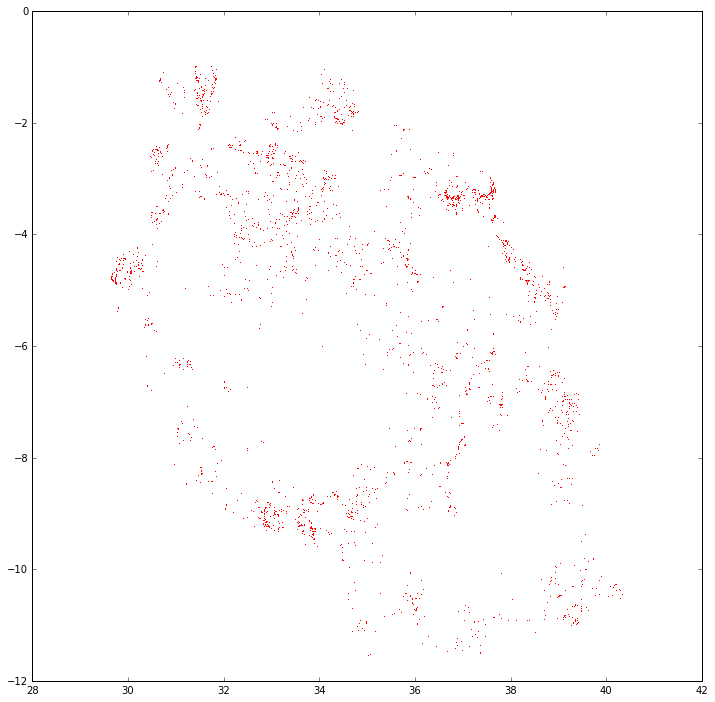

In [39]:
fig = plt.figure(figsize=(12,12))
plt.plot(mis['longitude'], mis['latitude'], ",r", alpha=1)

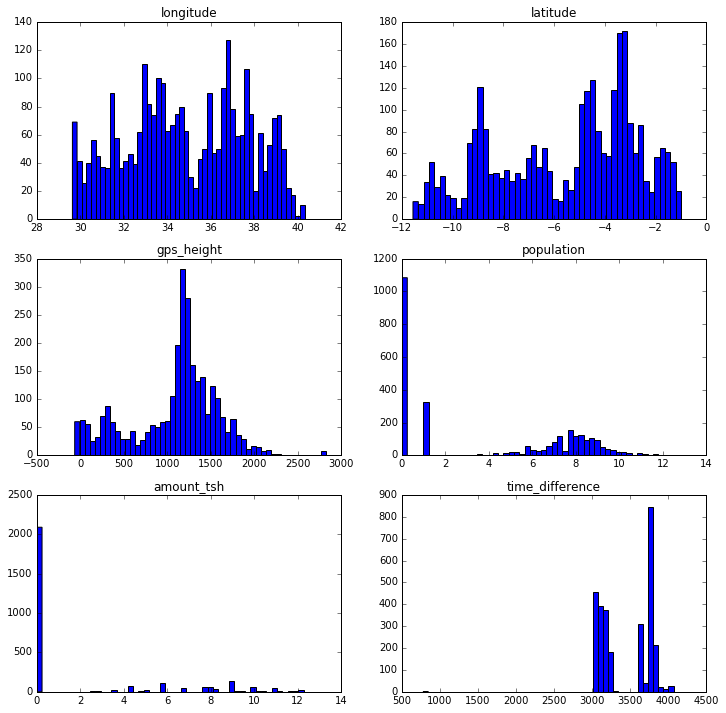

In [40]:
list_features = ['longitude', 'latitude', 'gps_height', 'population', 'amount_tsh', 'time_difference']
fig = plt.figure(figsize=(12,12))
for i in range(0, 6):
    plt.subplot(3, 2, i+1)
    plt.hist(mis[list_features[i]], 50)
    plt.title(list_features[i])
plt.show()

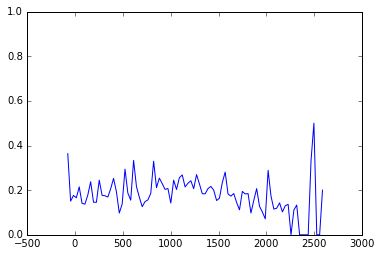

In [41]:
sub_cv = x_cv[x_cv['longitude'] != 0]

item = 'gps_height'
maximum = sub_cv[item].max()
minimum = sub_cv[item].min()

bin_size = (maximum - minimum)/100
num_right = np.zeros(100)
num_wrong = np.zeros(100)

for i in range(0, 100):
    lb = minimum
    ub = minimum + bin_size
    minimum += bin_size
    num_right[i] = correct[(correct[item] >= lb) & (correct[item] < ub)].shape[0]
    num_wrong[i] = mis[(mis[item] >= lb) & (mis[item] < ub)].shape[0]

percent = num_wrong / (num_wrong + num_right)
plt.plot(np.linspace(sub_cv[item].min(), sub_cv[item].max(), 100), percent)

# Training a different mdoel for cases where gps_height = 0

In [53]:
train1 = train[train['amount_tsh'] > 0]
train2 = train[train['amount_tsh'] == 0]

cv1 = cv[cv['amount_tsh'] > 0]
cv2 = cv[cv['amount_tsh'] == 0]

y_train1 = train1['status_group']
x_train1 = train1.drop(['status_group'], axis=1)
y_train2 = train2['status_group']
x_train2 = train2.drop(['status_group'], axis=1)

y_cv1 = cv1['status_group']
x_cv1 = cv1.drop(['status_group'], axis=1)
y_cv2 = cv2['status_group']
x_cv2 = cv2.drop(['status_group'], axis=1)

In [54]:
size1 = train1.shape[0]
size2 = train2.shape[0]
#size3 = train3.shape[0]
#size4 = train4.shape[0]
print(size1, size2) #, size3, size4)

8971 19871


In [55]:
model1 = RandomForestClassifier(n_estimators=100, max_depth=30, max_features='auto')
model1.fit(x_train1, y_train1)
train_accu1 = model1.score(x_train1, y_train1)
cv_accu1 = model1.score(x_cv1, y_cv1)
print("Training accuracy: ", train_accu1)
print("Cross validation accuracy: ", cv_accu1)

Training accuracy:  0.998662356482
Cross validation accuracy:  0.821670428894


In [56]:
model2 = RandomForestClassifier(n_estimators=100, max_depth=30, max_features='auto')
model2.fit(x_train2, y_train2)
train_accu2 = model2.score(x_train2, y_train2)
cv_accu2 = model2.score(x_cv2, y_cv2)
print("Training accuracy: ", train_accu2)
print("Cross validation accuracy: ", cv_accu2)

Training accuracy:  0.996779226008
Cross validation accuracy:  0.786084452975


In [52]:
# overall accuracy
(size1 * cv_accu1 + size2 * cv_accu2)/(size1 + size2)
#(size1 * cv_accu1 + size2 * cv_accu2 + size3 * cv_accu3 + size4 * cv_accu4)/(size1 + size2 + size3 + size4)

0.79561661613237344

# Plot accuracy against n_estimators

In [91]:
accuracy_cv = np.zeros(100)
accuracy_train = np.zeros(100)
for i in range(1, 101):
    model = RandomForestClassifier(n_estimators=i, max_depth=20, max_features='auto')
    model.fit(x_train, y_train)
    accuracy_cv[i - 1] = model.score(x_cv, y_cv)
    accuracy_train[i - 1] = model.score(x_train, y_train)

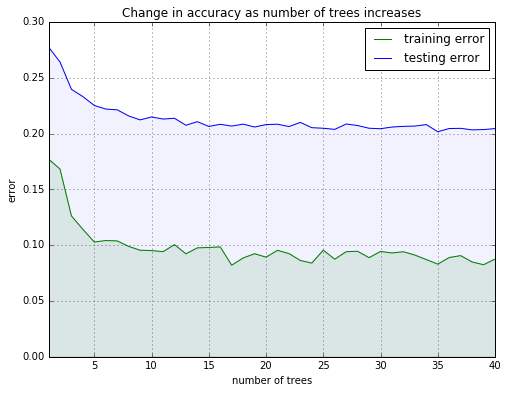

In [95]:
fig = plt.figure(figsize=(8,6))
x = np.linspace(1, 100, 100)
y1 = 1 - accuracy_train
y2 = 1 - accuracy_cv

plt.plot(x, y1, label='training error', color='green')
plt.plot(x, y2, label='testing error', color='blue')

plt.fill_between(x, 0, y2, where=y2 >= 0, facecolor='blue', alpha=0.05)
plt.fill_between(x, 0, y1, where=y1 >= 0, facecolor='green', alpha=0.1)

plt.title('Change in accuracy as number of trees increases')
plt.xlim(1, 40)
plt.ylabel("error")
plt.xlabel("number of trees")
plt.legend()
plt.grid()

plt.show()

In [105]:
importance = pd.DataFrame(modelrf.feature_importances_, columns=['Importance'])
feature = pd.DataFrame(x_train.columns, columns=['Feature'])
print("Number of features: ", feature.shape[0])
fi = feature.join(importance.ix[:,])
fi = fi.sort(['Importance'], ascending=False)
fi.head(30)

Number of features:  255


/Users/Fan/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Feature,Importance
2,longitude,0.112306
3,latitude,0.111667
4,gps_height,0.076041
210,quantity_dry,0.071109
10,time_difference,0.059078
5,construction_year,0.048214
0,population,0.043566
211,quantity_enough,0.026690
188,extraction_type_class_other,0.020945
234,waterpoint_type_other,0.020916
